In [355]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Get test data from database 

In [310]:
conn = sqlite3.connect('covid_data.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)


Tables in the database: [('states_table',), ('deaths_table',), ('vaccinations_table',), ('beds_table',)]


In [281]:
# Get df from database 
conn = sqlite3.connect('covid_data.db')

# Get deaths df
query_deaths = """
SELECT 
    state, 
    population,
    date,
    deaths
FROM 
    deaths_table
WHERE date >= '2022-01-01'
"""
df_deaths = pd.read_sql_query(query_deaths, conn)

# Get vaccinations df
query_vaccinations = """
SELECT 
    state,
    date,
    series_complete_yes,
    booster_doses
FROM 
    vaccinations_table
"""
df_vaccinations = pd.read_sql_query(query_vaccinations, conn)

# Get beds df
query_beds = """
SELECT 
    hospital_name, 
    week_date,
    state,
    beds,
    inpatient_beds
FROM 
    beds_table
WHERE week_date >= '2022-01-01'
"""
df_beds = pd.read_sql_query(query_beds, conn)

conn.close()

#df_deaths.to_csv('df_deaths.csv', index=False)
#df_vaccinations.to_csv('df_vaccinations.csv', index=False)
df_beds.to_csv('df_beds.csv', index=False)

In [282]:
# Data cleaning

# Harmonize the state records across three datasets
common_states = set(df_beds['state']) & set(df_deaths['state']) & set(df_vaccinations['state'])

df_deaths = df_deaths[df_deaths['state'].isin(common_states)]
df_vaccinations = df_vaccinations[df_vaccinations['state'].isin(common_states)]
df_beds = df_beds[df_beds['state'].isin(common_states)]


# df_beds -- Drop rows with empty dates
df_beds_weekly = df_beds.dropna(subset=['week_date'])
df_beds_weekly.rename(columns={'week_date': 'date'}, inplace=True)

In [283]:
#df_deaths.to_csv('df_deaths.csv', index=False)
#df_vaccinations.to_csv('df_vaccinations.csv', index=False)
df_beds_weekly.to_csv('df_beds_weekly.csv', index=False)

### Get train data from database

In [194]:
# Get df from database -- train
conn = sqlite3.connect('covid_data.db')

# Get deaths df -- train
query_deaths = """
SELECT 
    state, 
    population,
    date,
    deaths
FROM 
    deaths_table
WHERE date < '2022-01-01'
"""
df_deaths_train = pd.read_sql_query(query_deaths, conn)


# Get beds df -- train
query_beds = """
SELECT 
    hospital_name, 
    week_date,
    state,
    beds,
    inpatient_beds
FROM 
    beds_table
WHERE week_date < '2022-01-01'
"""
df_beds_train = pd.read_sql_query(query_beds, conn)

conn.close()

In [195]:
# Data cleaning

# Harmonize the state records across datasets
df_deaths_train = df_deaths_train[df_deaths_train['state'].isin(common_states)]
df_beds_train = df_beds_train[df_beds_train['state'].isin(common_states)]

In [59]:
#df_deaths_train.to_csv('df_deaths_train.csv', index=False)
#df_beds_train.to_csv('df_beds_train.csv', index=False)

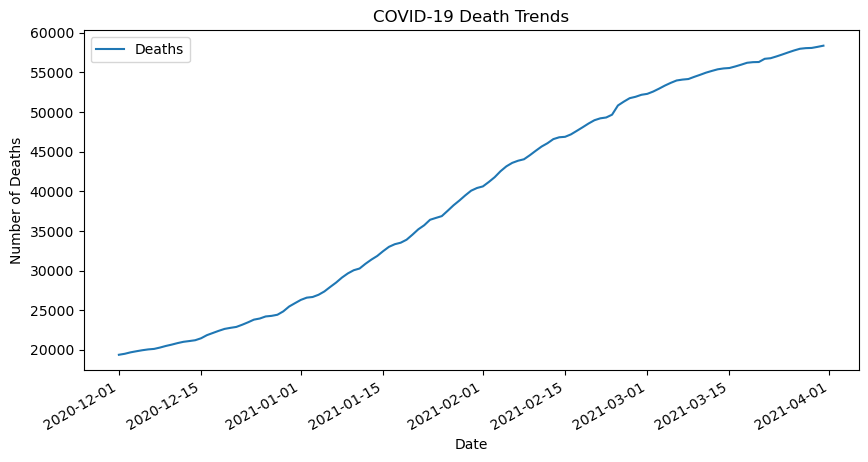

In [103]:
#删掉
df_ca_deaths = df_deaths_train[df_deaths_train['state'] == 'CA']
# 选择 'date' 和 'deaths' 列
df_ca_deaths = df_ca_deaths[['date', 'deaths']]
# 设置图形大小
plt.figure(figsize=(10, 5))
1
# 绘制死亡趋势
plt.plot(df_ca_deaths['date'], df_ca_deaths['deaths'], label='Deaths')

# 添加标题和标签
plt.title('COVID-19 Death Trends')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')

# 显示图例
plt.legend()

# 优化日期标签显示
plt.gcf().autofmt_xdate()  # 自动格式化日期标签，避免重叠

# 显示图形
plt.show()


### Predict mortality

In [105]:
# Step1: Predict deaths between Jan 2022 to Mar 2022
# Exponential model
def predict_deaths(df, state, start_date, end_date):
    df_state = df[df['state'] == state].copy()
    df_state['date'] = pd.to_datetime(df_state['date'])
    df_state['t'] = (df_state['date'] - df_state['date'].min()).dt.days
    df_state['log_deaths'] = np.log(df_state['deaths'] + 1)
    
    # Checking for data adequacy
    if df_state.empty or len(df_state) < 2:
        print(f"Not enough data for {state}")
        return None
    
    # Linear regression fitting log deaths
    lin_reg = LinearRegression()
    lin_reg.fit(df_state[['t']], df_state['log_deaths'])

    # Create a date range for the forecast
    df_predict = pd.DataFrame({
        'date': pd.date_range(start=start_date, end=end_date)
    })
    df_predict['t'] = (df_predict['date'] - df_state['date'].min()).dt.days
    df_predict['log_deaths'] = lin_reg.predict(df_predict[['t']])
    df_predict['predicted_deaths'] = np.exp(df_predict['log_deaths']) - 1
    df_predict['state'] = state
    
    # Round the predicted deaths to the nearest integer
    df_predict['predicted_deaths'] = df_predict['predicted_deaths'].round(0).astype(int)

    return df_predict[['state', 'date', 'predicted_deaths']]


states = df_deaths_train['state'].unique()
all_forecasts = []


for state in states:
    forecast_df = predict_deaths(df_deaths_train, state, '2022-01-01', '2022-03-31')
    if forecast_df is not None:
        all_forecasts.append(forecast_df)


df_pred_death = pd.concat(all_forecasts)
df_pred_death.to_csv('df_pred_death.csv', index=False)

下面要：
1.画一个trend图，包含predict_death, test death, vaccination
2.用predict death减去test death的差值，和vaccination对比，获得vaccination对death的影响，差值和vaccination画个图

### Trends in mortality and vaccination

In [126]:
# Trends in mortality and vaccination

def death_vaccination_trends(df_deaths, df_pred_death, df_vaccinations, state):
    # Clear the current figure's plot if any to prevent type conflicts
    plt.clf()
    
    df_deaths['date'] = pd.to_datetime(df_deaths['date'])
    df_pred_death['date'] = pd.to_datetime(df_pred_death['date'])
    df_vaccinations['date'] = pd.to_datetime(df_vaccinations['date'])
    
    # Select a state
    df_death_state = df_deaths[df_deaths['state'] == state]
    df_pred_death_state = df_pred_death[df_pred_death['state'] == state]
    df_vaccination_state = df_vaccinations[df_vaccinations['state'] == state]

    # Merge data
    df_merged = pd.merge(df_death_state, df_pred_death_state, on='date', how='outer')
    df_merged = pd.merge(df_merged, df_vaccination_state, on='date', how='outer')
    
    # Sort by date
    df_merged.sort_values('date', inplace=True)
    
    # Reset index and convert date to datetime64[ns] explicitly
    df_merged = df_merged.reset_index(drop=True)
    df_merged['date'] = df_merged['date'].astype('datetime64[ns]')

    
    plt.figure(figsize=(10, 6))

    # Plot mortality data
    line1, = plt.plot(df_merged['date'], df_merged['deaths'], label='Deaths', color='blue')
    line2, = plt.plot(df_merged['date'], df_merged['predicted_deaths'], label='Predicted Deaths', color='red')
    plt.xlabel('Date')
    plt.ylabel('Deaths')

    # Create secondary vertical axes
    ax2 = plt.gca().twinx()
    # Plot completed vaccination data
    line3, = ax2.plot(df_merged['date'], df_merged['series_complete_yes'], label='Vaccination Series Complete', color='orange', linestyle='--')
    # Plot booster dose data
    line4, = ax2.plot(df_merged['date'], df_merged['booster_doses'], label='Booster Doses', color='green', linestyle='--')


    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SU, interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gcf().autofmt_xdate()
    
    start_date = '2022-01-02'
    end_date = df_merged['date'].max()
    plt.xlim(pd.to_datetime(start_date), end_date)


    plt.title(f'COVID-19 Deaths and Vaccination Trends in {state}')
    ax2.set_ylabel('Vaccinations')
    
    plt.legend(handles=[line1, line2, line3, line4], loc='upper left')

    plt.show()

<Figure size 640x480 with 0 Axes>

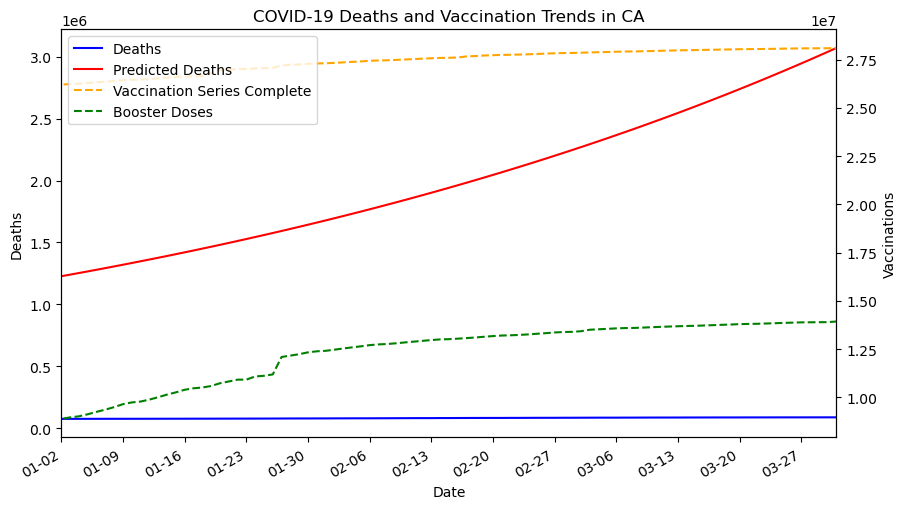

In [127]:
death_vaccination_trends(df_deaths, df_pred_death, df_vaccinations, 'CA')

In [132]:
# Trends in the difference between predicted and actual deaths and vaccination

def vaccination_effect_on_death_trends(df_deaths, df_pred_death, df_vaccinations, state):
    # Clear the current figure's plot if any to prevent type conflicts
    plt.clf()
    
    df_deaths['date'] = pd.to_datetime(df_deaths['date'])
    df_pred_death['date'] = pd.to_datetime(df_pred_death['date'])
    df_vaccinations['date'] = pd.to_datetime(df_vaccinations['date'])

    # Select a state
    df_death_state = df_deaths[df_deaths['state'] == state]
    df_pred_death_state = df_pred_death[df_pred_death['state'] == state]
    df_vaccination_state = df_vaccinations[df_vaccinations['state'] == state]

    # Merge the death and predicted death data
    df_merged = pd.merge(df_death_state, df_pred_death_state, on='date', how='inner')
    # Calculate the difference between predicted and actual deaths
    df_merged['death_difference'] = df_merged['predicted_deaths'] - df_merged['deaths']

    # Merge the vaccination data
    df_merged = pd.merge(df_merged, df_vaccination_state, on='date', how='inner')

    # Sort by date
    df_merged.sort_values('date', inplace=True)

    plt.figure(figsize=(10, 6))

    # Plot the death difference
    line1, = plt.plot(df_merged['date'], df_merged['death_difference'], label='Death Difference', color='purple')
    plt.xlabel('Date')
    plt.ylabel('Death Difference')
    
    # Create secondary vertical axes for vaccinations
    ax2 = plt.gca().twinx()

    # Plot completed vaccination data
    line2, = ax2.plot(df_merged['date'], df_merged['series_complete_yes'], label='Vaccination Series Complete', color='orange', linestyle='--')
    # Plot booster dose data
    line3, = ax2.plot(df_merged['date'], df_merged['booster_doses'], label='Booster Doses', color='green', linestyle='--')

    
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SU, interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gcf().autofmt_xdate()

    start_date = '2022-01-02'
    end_date = df_merged['date'].max()
    plt.xlim(pd.to_datetime(start_date), end_date)


    plt.title(f'Effect of Vaccination on Death Trends in {state}')
    ax2.set_ylabel('Vaccinations')
    
    plt.legend(handles=[line1, line2, line3], loc='upper left')

    plt.show()

<Figure size 640x480 with 0 Axes>

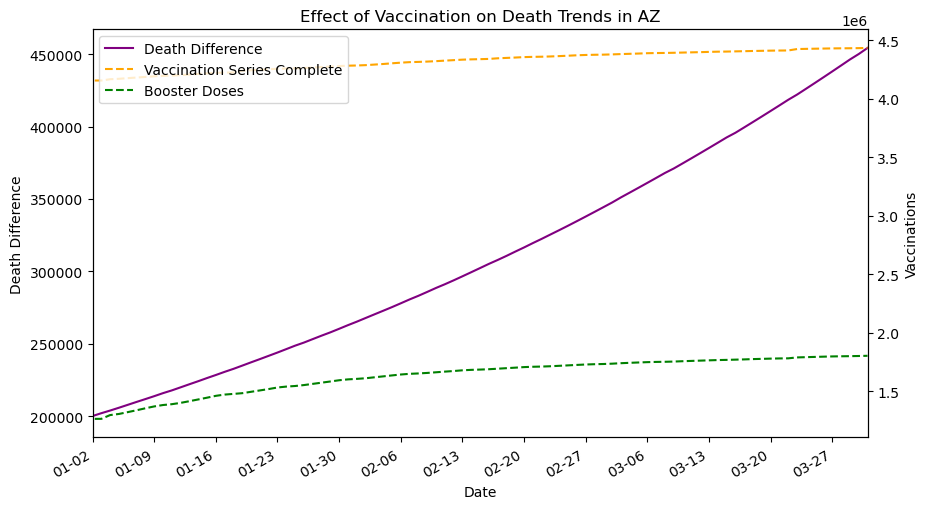

In [137]:
vaccination_effect_on_death_trends(df_deaths, df_pred_death, df_vaccinations, 'AZ')

In [344]:
# Scatter plot

def vaccination_effect_on_death_scatter(df_deaths, df_pred_death, df_vaccinations, state):
    plt.clf()

    df_deaths['date'] = pd.to_datetime(df_deaths['date'])
    df_pred_death['date'] = pd.to_datetime(df_pred_death['date'])
    df_vaccinations['date'] = pd.to_datetime(df_vaccinations['date'])

    # Filter data by state
    df_death_state = df_deaths[df_deaths['state'] == state]
    df_pred_death_state = df_pred_death[df_pred_death['state'] == state]
    df_vaccination_state = df_vaccinations[df_vaccinations['state'] == state]

    # Merge the death and predicted death data
    df_merged = pd.merge(df_death_state, df_pred_death_state, on='date', how='inner')
    df_merged['death_difference'] = df_merged['predicted_deaths'] - df_merged['deaths']

    # Merge the vaccination data
    df_merged = pd.merge(df_merged, df_vaccination_state, on='date', how='inner')

    # Sort by date
    df_merged.sort_values('date', inplace=True)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Scatter plot for series completions
    plt.scatter(df_merged['series_complete_yes'], df_merged['death_difference'], color='orange', label='Series Completions')
    # Scatter plot for booster doses
    plt.scatter(df_merged['booster_doses'], df_merged['death_difference'], color='green', label='Booster Doses')

    # Calculate correlation coefficients
    corr_coef_series = df_merged['series_complete_yes'].corr(df_merged['death_difference'])
    corr_coef_booster = df_merged['booster_doses'].corr(df_merged['death_difference'])

    plt.xlabel('Number of Vaccinations')
    plt.ylabel('Death Difference')
    plt.title(f'Scatter Plot of Vaccination vs Death Difference in {state}')
    plt.legend()

    # Adding text for correlation coefficients
    plt.figtext(0.5, 0.8, f'Correlation (Series Completions): {corr_coef_series:.2f}', fontsize=10, backgroundcolor='orange', color='white')
    plt.figtext(0.5, 0.75, f'Correlation (Booster Doses): {corr_coef_booster:.2f}', fontsize=10, backgroundcolor='green', color='white')


    plt.show()
    #plt.xlabel('Number of Vaccinations')
    #plt.ylabel('Death Difference')
    #plt.title(f'Scatter Plot of Vaccination vs Death Difference in {state}')
    #plt.legend()
    
    #plt.show()
    


<Figure size 640x480 with 0 Axes>

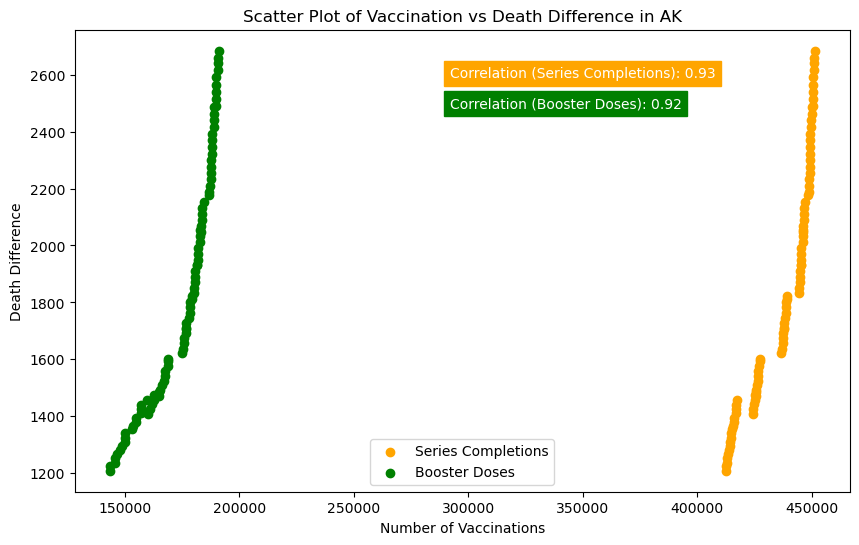

In [349]:
vaccination_effect_on_death_scatter(df_deaths, df_pred_death, df_vaccinations, 'AK')

### Trends in hospital load and vaccination

In [297]:
# Data preprocessing

# Aggregate vaccination data on a weekly basis
df_vaccinations['date'] = pd.to_datetime(df_vaccinations['date'])

start_date = '2022-01-02'

df_vaccinations_weekly = df_vaccinations.groupby(
    ['state', pd.Grouper(key='date', freq='W-SUN', origin=pd.Timestamp(start_date))]
)[['series_complete_yes', 'booster_doses']].mean().reset_index()

# Aggregate beds data based on states
df_total_beds = df_beds_weekly.groupby(['date','state'])['inpatient_beds'].sum().reset_index()

#df_total_beds.to_csv('df_total_beds.csv', index=False)
#df_vaccinations_weekly.to_csv('df_vaccinations_weekly.csv', index=False)

In [308]:
# Trends in hospital load and vaccination
def beds_vaccination_trends(df_total_beds, df_vaccinations_weekly, state):
    plt.clf()
    
    df_total_beds['date'] = pd.to_datetime(df_total_beds['date'])
    df_vaccinations_weekly['date'] = pd.to_datetime(df_vaccinations_weekly['date'])
    
    # Filter data by state
    df_total_beds_state = df_total_beds[df_total_beds['state'] == state]
    df_vaccinations_weekly_state = df_vaccinations_weekly[df_vaccinations_weekly['state'] == state]
    
    # Merge beds and vaccination data
    df_merged = pd.merge(df_total_beds_state, df_vaccinations_weekly_state, on='date', how='inner')
  
    # Sort by date for plotting
    df_merged.sort_values('date', inplace=True)
    

    plt.figure(figsize=(12, 6))
    
    #line1, = plt.bar(df_merged['date'], df_merged['inpatient_beds'], label='Inpatient Beds', color='blue', width=5, align='center')
    line1, = plt.plot(df_merged['date'], df_merged['inpatient_beds'], label='Inpatient Beds', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Inpatient Beds')
    
    # Create a secondary y-axis for vaccination rates
    ax2 = plt.gca().twinx()
    # Plot completed vaccination data
    line2, = ax2.plot(df_merged['date'], df_merged['series_complete_yes'], label='Vaccination Series Complete', color='orange', linestyle='--')
    # Plot booster dose data
    line3, = ax2.plot(df_merged['date'], df_merged['booster_doses'], label='Booster Doses', color='green', linestyle='--')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gcf().autofmt_xdate()

    plt.title(f'Inpatient Beds and Vaccination Trends in {state}')
    ax2.set_ylabel('Vaccinations')
    
    plt.legend(handles=[line1, line2, line3], loc='upper left')

    plt.show()


<Figure size 640x480 with 0 Axes>

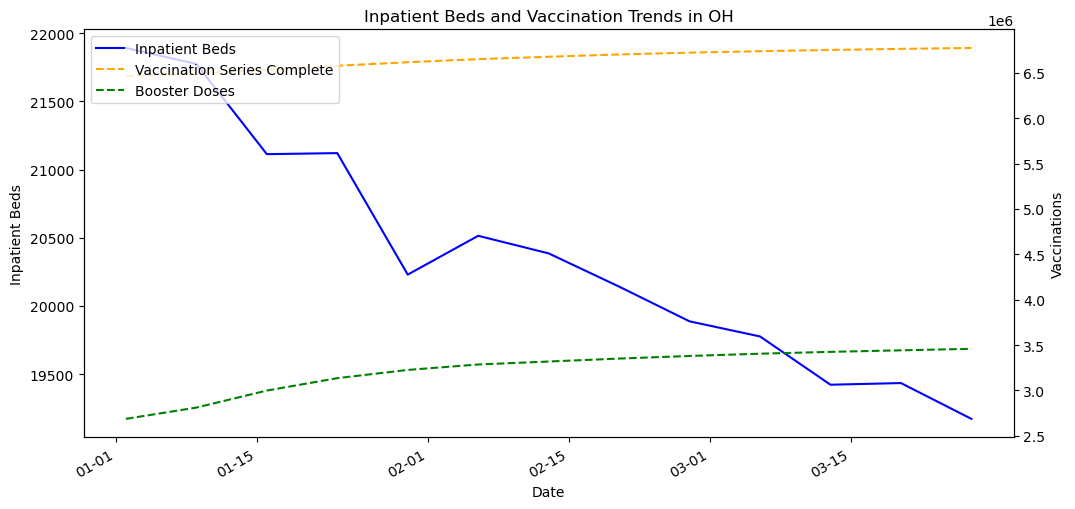

In [329]:
beds_vaccination_trends(df_total_beds, df_vaccinations_weekly, 'OH')

In [362]:
# Trends in hospital load and vaccination -- by hospital

def list_hospitals_by_state(state):
    
    filtered_df = df_beds_weekly[df_beds_weekly['state'] == state]
    return filtered_df['hospital_name'].tolist()

# 示例使用函数
state_input = "CA"  # 你可以改变这个值来测试不同的州
hospitals = list_hospitals_by_state(state_input)

In [379]:
# Trends in hospital load and vaccination -- by hospital
# 先搞一个能列出每个州的医院的list，再搜每个医院的trend
def beds_vaccination_trends(df_beds_weekly, df_vaccinations_weekly, state, name):
    plt.clf()
    
    df_beds_weekly['date'] = pd.to_datetime(df_beds_weekly['date'])
    df_vaccinations_weekly['date'] = pd.to_datetime(df_vaccinations_weekly['date'])

    
    # Convert state codes to lower case for case-insensitive matching
    df_beds_weekly = df_beds_weekly.copy()
    df_beds_weekly.loc[:, 'state'] = df_beds_weekly['state'].str.lower()
    df_vaccinations_weekly.loc[:, 'state'] = df_vaccinations_weekly['state'].str.lower()
    state_lower = state.lower()
    
    # Filter data by state
    df_beds_weekly_state = df_beds_weekly[df_beds_weekly['state'] == state_lower]
    df_vaccinations_weekly_state = df_vaccinations_weekly[df_vaccinations_weekly['state'] == state_lower]
    
    # Convert hospital names to lower case for case-insensitive matching
    df_beds_weekly_state = df_beds_weekly_state.copy()
    df_beds_weekly_state.loc[:, 'hospital_name'] = df_beds_weekly_state['hospital_name'].str.lower()
    name_lower = name.lower()
    
    # Further filter data by hospital name
    df_beds_specific_hospital = df_beds_weekly_state[df_beds_weekly_state['hospital_name'] == name_lower]
    
    # Merge beds and vaccination data
    df_merged = pd.merge(df_beds_specific_hospital, df_vaccinations_weekly_state, on='date', how='outer')
  
    # Sort by date for plotting
    df_merged.sort_values('date', inplace=True)
    

    plt.figure(figsize=(12, 6))
    
    #line1, = plt.bar(df_merged['date'], df_merged['inpatient_beds'], label='Inpatient Beds', color='blue', width=5, align='center')
    line1, = plt.plot(df_merged['date'], df_merged['inpatient_beds'], label='Inpatient Beds', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Inpatient Beds')
    
    # Create a secondary y-axis for vaccination rates
    ax2 = plt.gca().twinx()
    # Plot completed vaccination data
    line2, = ax2.plot(df_merged['date'], df_merged['series_complete_yes'], label='Vaccination Series Complete', color='orange', linestyle='--')
    # Plot booster dose data
    line3, = ax2.plot(df_merged['date'], df_merged['booster_doses'], label='Booster Doses', color='green', linestyle='--')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gcf().autofmt_xdate()

    plt.title(f'Inpatient Beds and Vaccination Trends in {name}')
    ax2.set_ylabel('Vaccinations')
    
    plt.legend(handles=[line1, line2, line3], loc='upper left')

    plt.show()

<Figure size 640x480 with 0 Axes>

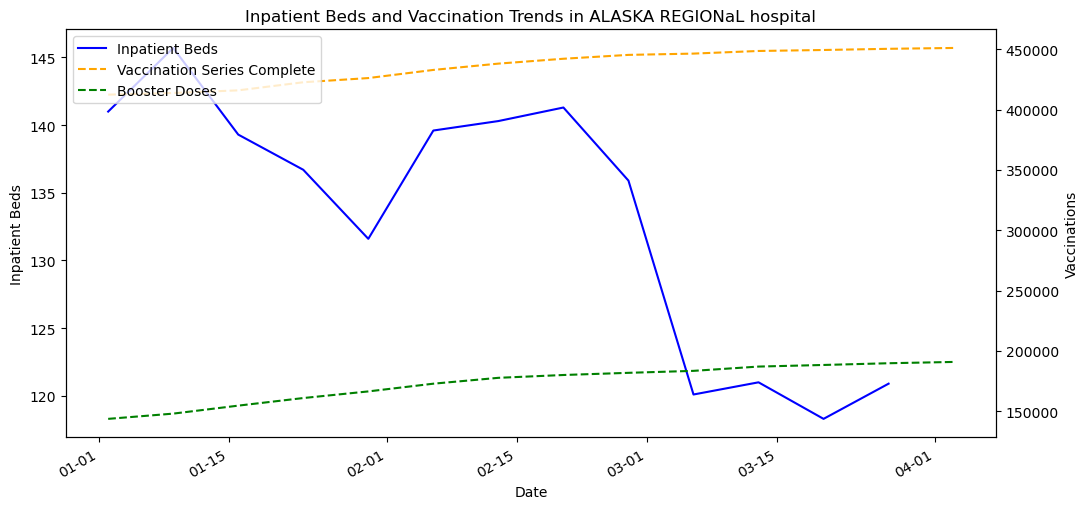

In [380]:
beds_vaccination_trends(df_beds_weekly, df_vaccinations_weekly, 'ak', 'ALASKA REGIONaL hospital')

In [316]:
# Trends in the difference between predicted and actual beds and vaccination

# Step1: Predict inpatient beds between Jan 2022 to Mar 2022
# Aggregate beds data based on states -- train
df_total_beds_train = df_beds_train.groupby(['week_date','state'])['inpatient_beds'].sum().reset_index()
df_total_beds_train.rename(columns={'week_date': 'date'}, inplace=True)

#df_total_beds_train.to_csv('df_total_beds_train.csv', index=False)

In [ ]:
# Predict inpatient beds
def predict_beds(df, state, start_date, end_date):
    df_state = df[df['state'] == state].copy()
    df_state['date'] = pd.to_datetime(df_state['date'])
    df_state['t'] = (df_state['date'] - df_state['date'].min()).dt.days
    df_state['log_deaths'] = np.log(df_state['deaths'] + 1)
    
    # Checking for data adequacy
    if df_state.empty or len(df_state) < 2:
        print(f"Not enough data for {state}")
        return None
    
    # Linear regression fitting log deaths
    lin_reg = LinearRegression()
    lin_reg.fit(df_state[['t']], df_state['log_deaths'])


### Prediction

In [358]:
# Predict vaccination and deaths
def predict_vaccination_effect_on_death(df_deaths, df_vaccinations, state):
    # Clear the current figure's plot if any to prevent type conflicts
    plt.clf()
    
    df_deaths['date'] = pd.to_datetime(df_deaths['date'])
    df_vaccinations['date'] = pd.to_datetime(df_vaccinations['date'])

    # Select a state
    df_death_state = df_deaths[df_deaths['state'] == state]
    df_vaccination_state = df_vaccinations[df_vaccinations['state'] == state]

    # Merge the death and predicted death data
    df_merged = pd.merge(df_death_state, df_vaccination_state, on='date', how='inner')
    
    X = df_merged[['series_complete_yes']]
    y = df_merged['deaths']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForeast()
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    return MSE

In [359]:
predict_vaccination_effect_on_death(df_deaths, df_vaccinations, 'CA')

NameError: name 'RandomForeast' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
def death_vaccination_trends(df_deaths, df_pred_death, df_vaccinations, state):
    # Clear the current figure's plot if any to prevent type conflicts
    plt.clf()
    
    df_deaths['date'] = pd.to_datetime(df_deaths['date'], errors='coerce')
    df_pred_death['date'] = pd.to_datetime(df_pred_death['date'], errors='coerce')
    df_vaccinations['date'] = pd.to_datetime(df_vaccinations['date'], errors='coerce')
    
    # Select a state
    df_death_state = df_deaths[df_deaths['state'] == state]
    df_pred_death_state = df_pred_death[df_pred_death['state'] == state]
    df_vaccination_state = df_vaccinations[df_vaccinations['state'] == state]

    # Merge data
    df_merged = pd.merge(df_death_state, df_pred_death_state, on='date', how='outer')
    df_merged = pd.merge(df_merged, df_vaccination_state, on='date', how='outer')
    
    # Sort by date
    df_merged.sort_values('date', inplace=True)
    df_merged = df_merged.reset_index(drop=True)

    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mortality data
    line1, = ax1.plot(df_merged['date'], df_merged['deaths'], label='Deaths', color='blue')
    line2, = ax1.plot(df_merged['date'], df_merged['predicted_deaths'], label='Predicted Deaths', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Deaths')

    # Create secondary vertical axes
    ax2 = ax1.twinx()
    # Plot completed vaccination data
    line3, = ax2.plot(df_merged['date'], df_merged['series_complete_yes'], label='Vaccination Series Complete', color='orange', linestyle='--')
    # Plot booster dose data
    line4, = ax2.plot(df_merged['date'], df_merged['booster_doses'], label='Booster Doses', color='green', linestyle='--')
    ax2.set_ylabel('Vaccinations')

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SU, interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    fig.autofmt_xdate()
    
    start_date = pd.to_datetime('2022-01-02')
    end_date = pd.to_datetime('2022-03-31')
    ax1.set_xlim(start_date, end_date)


    ax1.set_title(f'COVID-19 Deaths and Vaccination Trends in {state}')
    ax1.legend(handles=[line1, line2, line3, line4], loc='upper left')

    st.pyplot(fig)

In [ ]:
    # Convert state codes to lower case for case-insensitive matching
    df_beds_weekly = df_beds_weekly.copy()
    df_beds_weekly.loc[:, 'state'] = df_beds_weekly['state'].str.lower()
    df_vaccinations_weekly.loc[:, 'state'] = df_vaccinations_weekly['state'].str.lower()
    state_lower = state.lower()
    
    # Filter data by state
    df_beds_weekly_state = df_beds_weekly[df_beds_weekly['state'] == state_lower]
    df_vaccinations_weekly_state = df_vaccinations_weekly[df_vaccinations_weekly['state'] == state_lower]